
    Year: The year in which the flight took place.
    Month: The month in which the flight took place.
    DayofMonth: The day of the month on which the flight took place.
    DayOfWeek: The week day on which the flight took place.
    Carrier: The airline operating the flight.
    OriginAirportID: A numeric code indicating the departure airport.
    DestAirportID: A numeric code indicating the destination airport.
    CRSDepTime: The scheduled departure time in 24-hour format.
    DepDelay: The number of minutes late or early that the flight departed.
    DepDel15: A Boolean column indicating whether or not the flight departed 15 minutes or more late.
    CRSArrTime: The scheduled arrival time.
    ArrDelay: The number of minutes late or early that the flight arrived.
    ArrDel15: Whether or not the flight arrived 15 or minutes more late.
    Cancelled: Whether or not the flight was cancelled.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from xgboost import to_graphviz, plot_importance

from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import _hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor, HistGradientBoostingRegressor
%matplotlib inline

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report, mean_absolute_error, mean_squared_error,r2_score
from sklearn.metrics import plot_confusion_matrix, plot_precision_recall_curve, plot_roc_curve

import keras
from keras.models import save_model, Sequential
from keras.layers import Activation, BatchNormalization, Dense
from keras.optimizers import Adam

pd.options.display.max_columns= None
#pd.options.display.max_rows = None

Using TensorFlow backend.


### Data Exploration

In [2]:
df = pd.read_csv("flights.csv",low_memory=False)

In [3]:
df

,Year,Month,DayofMonth,DayOfWeek,Carrier,OriginAirportID,DestAirportID,CRSDepTime,DepDelay,DepDel15,CRSArrTime,ArrDelay,ArrDel15,Cancelled
0,2013,4,19,5,DL,11433,13303,837,-3.0,0.0,1138,1.0,0,0
1,2013,4,19,5,DL,14869,12478,1705,0.0,0.0,2336,-8.0,0,0
2,2013,4,19,5,DL,14057,14869,600,-4.0,0.0,851,-15.0,0,0
3,2013,4,19,5,DL,15016,11433,1630,28.0,1.0,1903,24.0,1,0
4,2013,4,19,5,DL,11193,12892,1615,-6.0,0.0,1805,-11.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2719413,2013,10,19,6,DL,13204,14869,730,1.0,0.0,1013,-3.0,0,0
2719414,2013,10,19,6,DL,10397,13495,944,-2.0,0.0,1018,-3.0,0,0
2719415,2013,10,19,6,DL,10140,10397,1312,18.0,1.0,1807,9.0,0,0
2719416,2013,10,19,6,DL,10397,13244,1735,10.0,0.0,1757,7.0,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2719418 entries, 0 to 2719417
Data columns (total 14 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Year             int64  
 1   Month            int64  
 2   DayofMonth       int64  
 3   DayOfWeek        int64  
 4   Carrier          object 
 5   OriginAirportID  int64  
 6   DestAirportID    int64  
 7   CRSDepTime       int64  
 8   DepDelay         float64
 9   DepDel15         float64
 10  CRSArrTime       int64  
 11  ArrDelay         float64
 12  ArrDel15         int64  
 13  Cancelled        int64  
dtypes: float64(3), int64(10), object(1)
memory usage: 290.5+ MB


In [5]:
df.describe(include='all')

,Year,Month,DayofMonth,DayOfWeek,Carrier,OriginAirportID,DestAirportID,CRSDepTime,DepDelay,DepDel15,CRSArrTime,ArrDelay,ArrDel15,Cancelled
count,2719418.0,2.719418e+06,2.719418e+06,2.719418e+06,2719418,2.719418e+06,2.719418e+06,2.719418e+06,2.691974e+06,2.691974e+06,2.719418e+06,2.690385e+06,2.719418e+06,2.719418e+06
unique,NaN,NaN,NaN,NaN,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,WN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,580029,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,2013.0,6.979968e+00,1.579747e+01,3.898391e+00,NaN,1.274226e+04,1.274246e+04,1.326645e+03,1.053687e+01,2.023419e-01,1.505270e+03,6.637688e+00,2.166316e-01,1.067618e-02
std,0.0,1.984331e+00,8.799860e+00,1.985988e+00,NaN,1.501973e+03,1.501969e+03,4.713766e+02,3.609953e+01,4.017458e-01,4.939662e+02,3.864881e+01,4.119496e-01,1.027726e-01
min,2013.0,4.000000e+00,1.000000e+00,1.000000e+00,NaN,1.014000e+04,1.014000e+04,1.000000e+00,-6.300000e+01,0.000000e+00,1.000000e+00,-9.400000e+01,0.000000e+00,0.000000e+00
25%,2013.0,5.000000e+00,8.000000e+00,2.000000e+00,NaN,1.129200e+04,1.129200e+04,9.200000e+02,-4.000000e+00,0.000000e+00,1.120000e+03,-1.100000e+01,0.000000e+00,0.000000e+00
50%,2013.0,7.000000e+00,1.600000e+01,4.000000e+00,NaN,1.289200e+04,1.289200e+04,1.320000e+03,-1.000000e+00,0.000000e+00,1.528000e+03,-3.000000e+00,0.000000e+00,0.000000e+00
75%,2013.0,9.000000e+00,2.300000e+01,6.000000e+00,NaN,1.405700e+04,1.405700e+04,1.725000e+03,9.000000e+00,0.000000e+00,1.918000e+03,1.000000e+01,0.000000e+00,0.000000e+00


In [6]:
df.isnull().sum()

Year                   0
Month                  0
DayofMonth             0
DayOfWeek              0
Carrier                0
OriginAirportID        0
DestAirportID          0
CRSDepTime             0
DepDelay           27444
DepDel15           27444
CRSArrTime             0
ArrDelay           29033
ArrDel15               0
Cancelled              0
dtype: int64

In [7]:
df.duplicated().sum()

0

In [8]:
df.shape

(2719418, 14)

In [9]:
df['Carrier'].value_counts()

WN    580029
DL    385040
AA    291771
UA    287601
US    235031
OO    161102
EV    158253
B6    122297
MQ    113634
FL     93013
9E     80221
AS     69056
YV     53022
F9     35821
VX     34869
HA     18658
Name: Carrier, dtype: int64

In [10]:
df['OriginAirportID'].nunique()

70

In [11]:
df['DestAirportID'].nunique()

70

In [12]:
df['DepDel15'].value_counts()

0.0    2147275
1.0     544699
Name: DepDel15, dtype: int64

In [13]:
df['ArrDel15'].value_counts()

0    2130306
1     589112
Name: ArrDel15, dtype: int64

In [14]:
df['Cancelled'].value_counts()

0    2690385
1      29033
Name: Cancelled, dtype: int64

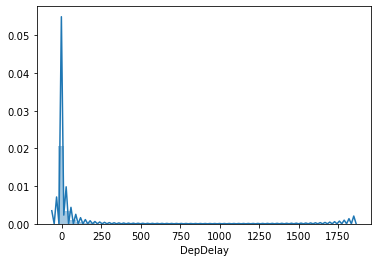

In [15]:
sns.distplot(a=df.DepDelay)
plt.show()

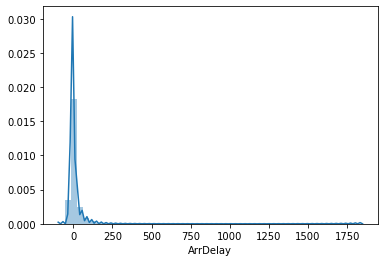

In [16]:
sns.distplot(a=df.ArrDelay)
plt.show()

### Remove all dates and times

In [17]:
df = df.drop(['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'OriginAirportID', 'DestAirportID' ,
              'CRSDepTime', 'CRSArrTime'],axis=1)

In [18]:
df

,Carrier,DepDelay,DepDel15,ArrDelay,ArrDel15,Cancelled
0,DL,-3.0,0.0,1.0,0,0
1,DL,0.0,0.0,-8.0,0,0
2,DL,-4.0,0.0,-15.0,0,0
3,DL,28.0,1.0,24.0,1,0
4,DL,-6.0,0.0,-11.0,0,0
...,...,...,...,...,...,...
2719413,DL,1.0,0.0,-3.0,0,0
2719414,DL,-2.0,0.0,-3.0,0,0
2719415,DL,18.0,1.0,9.0,0,0
2719416,DL,10.0,0.0,7.0,0,0


In [19]:
df.isnull().sum()

Carrier          0
DepDelay     27444
DepDel15     27444
ArrDelay     29033
ArrDel15         0
Cancelled        0
dtype: int64

### Drop all NaNs

In [20]:
df.dropna(inplace=True)

In [21]:
df.isnull().sum()

Carrier      0
DepDelay     0
DepDel15     0
ArrDelay     0
ArrDel15     0
Cancelled    0
dtype: int64

In [22]:
df.reset_index(drop=True,inplace=True)

In [23]:
df

,Carrier,DepDelay,DepDel15,ArrDelay,ArrDel15,Cancelled
0,DL,-3.0,0.0,1.0,0,0
1,DL,0.0,0.0,-8.0,0,0
2,DL,-4.0,0.0,-15.0,0,0
3,DL,28.0,1.0,24.0,1,0
4,DL,-6.0,0.0,-11.0,0,0
...,...,...,...,...,...,...
2690380,DL,1.0,0.0,-3.0,0,0
2690381,DL,-2.0,0.0,-3.0,0,0
2690382,DL,18.0,1.0,9.0,0,0
2690383,DL,10.0,0.0,7.0,0,0


In [24]:
#df.to_csv("train.csv",index=False)

### Load test data and reshape it

In [25]:
df2 = pd.read_csv("Test-Flights.csv")

In [26]:
df2

,Row ID,Year,Month,DayofMonth,DayOfWeek,Carrier,OriginAirportID,DestAirportID,CRSDepTime,DepDelay,DepDel15,CRSArrTime,ArrDelay,ArrDel15,Cancelled
0,1,2013,6,10,1,YV,14107,10800,1415,2,0,1534,0,0,0
1,2,2013,10,14,1,DL,10397,13244,2030,-2,0,2055,0,0,0
2,3,2013,6,19,3,AS,13891,14747,615,-3,0,848,0,0,0
3,4,2013,10,13,7,EV,10693,12953,950,-7,0,1302,0,0,0
4,5,2013,9,13,5,WN,13232,12191,1930,10,0,2155,0,0,0
5,6,2013,7,1,1,WN,11292,13198,1020,20,1,1255,0,0,0
6,7,2013,8,16,5,WN,13204,10529,945,-2,0,1220,0,0,0
7,8,2013,6,26,3,EV,11618,11433,600,283,1,751,0,0,0
8,9,2013,10,23,3,OO,13851,12266,1203,-1,0,1327,0,0,0
9,10,2013,10,30,3,EV,13198,13930,600,-8,0,722,0,0,0


In [27]:
df2 = df2.drop(['Row ID','Year', 'Month', 'DayofMonth', 'DayOfWeek', 'OriginAirportID', 'DestAirportID' ,
              'CRSDepTime', 'CRSArrTime'],axis=1)

In [28]:
df2

,Carrier,DepDelay,DepDel15,ArrDelay,ArrDel15,Cancelled
0,YV,2,0,0,0,0
1,DL,-2,0,0,0,0
2,AS,-3,0,0,0,0
3,EV,-7,0,0,0,0
4,WN,10,0,0,0,0
5,WN,20,1,0,0,0
6,WN,-2,0,0,0,0
7,EV,283,1,0,0,0
8,OO,-1,0,0,0,0
9,EV,-8,0,0,0,0


In [29]:
df2.isnull().sum()

Carrier      0
DepDelay     0
DepDel15     0
ArrDelay     0
ArrDel15     0
Cancelled    0
dtype: int64

In [30]:
#df2.to_csv("test.csv",index=False)

### Normalised

In [31]:
df3 = pd.concat([df,df2],axis=0)

In [32]:
df3

,Carrier,DepDelay,DepDel15,ArrDelay,ArrDel15,Cancelled
0,DL,-3.0,0.0,1.0,0,0
1,DL,0.0,0.0,-8.0,0,0
2,DL,-4.0,0.0,-15.0,0,0
3,DL,28.0,1.0,24.0,1,0
4,DL,-6.0,0.0,-11.0,0,0
...,...,...,...,...,...,...
20,UA,3.0,0.0,0.0,0,0
21,UA,7.0,0.0,0.0,0,0
22,9E,-6.0,0.0,0.0,0,0
23,WN,14.0,0.0,0.0,0,0


In [33]:
df3.reset_index(drop=True, inplace=True)

In [34]:
df3

,Carrier,DepDelay,DepDel15,ArrDelay,ArrDel15,Cancelled
0,DL,-3.0,0.0,1.0,0,0
1,DL,0.0,0.0,-8.0,0,0
2,DL,-4.0,0.0,-15.0,0,0
3,DL,28.0,1.0,24.0,1,0
4,DL,-6.0,0.0,-11.0,0,0
...,...,...,...,...,...,...
2690405,UA,3.0,0.0,0.0,0,0
2690406,UA,7.0,0.0,0.0,0,0
2690407,9E,-6.0,0.0,0.0,0,0
2690408,WN,14.0,0.0,0.0,0,0


In [35]:
#df3.to_csv("all.csv",index=False)

In [36]:
df4 = pd.get_dummies(df3,drop_first=True)

In [37]:
df4

,DepDelay,DepDel15,ArrDelay,ArrDel15,Cancelled,Carrier_AA,Carrier_AS,Carrier_B6,Carrier_DL,Carrier_EV,Carrier_F9,Carrier_FL,Carrier_HA,Carrier_MQ,Carrier_OO,Carrier_UA,Carrier_US,Carrier_VX,Carrier_WN,Carrier_YV
0,-3.0,0.0,1.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,0.0,0.0,-8.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,-4.0,0.0,-15.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,28.0,1.0,24.0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,-6.0,0.0,-11.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2690405,3.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2690406,7.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2690407,-6.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2690408,14.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [38]:
#df4.to_csv("all.csv",index=False)

### Rearrange the columns

In [39]:
df5 = df4[['DepDelay','DepDel15', 'ArrDel15', 'Cancelled', 'Carrier_AA' ,'Carrier_AS', 'Carrier_B6', 'Carrier_DL',
           'Carrier_EV', 'Carrier_F9', 'Carrier_FL', 'Carrier_HA', 'Carrier_MQ', 'Carrier_OO', 'Carrier_UA',
           'Carrier_US', 'Carrier_VX', 'Carrier_WN', 'Carrier_YV', 'ArrDelay']]

In [40]:
df5

,DepDelay,DepDel15,ArrDel15,Cancelled,Carrier_AA,Carrier_AS,Carrier_B6,Carrier_DL,Carrier_EV,Carrier_F9,Carrier_FL,Carrier_HA,Carrier_MQ,Carrier_OO,Carrier_UA,Carrier_US,Carrier_VX,Carrier_WN,Carrier_YV,ArrDelay
0,-3.0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1.0
1,0.0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,-8.0
2,-4.0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,-15.0
3,28.0,1.0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,24.0
4,-6.0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,-11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2690405,3.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.0
2690406,7.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.0
2690407,-6.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0
2690408,14.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.0


In [41]:
df5.isnull().sum()

DepDelay      0
DepDel15      0
ArrDel15      0
Cancelled     0
Carrier_AA    0
Carrier_AS    0
Carrier_B6    0
Carrier_DL    0
Carrier_EV    0
Carrier_F9    0
Carrier_FL    0
Carrier_HA    0
Carrier_MQ    0
Carrier_OO    0
Carrier_UA    0
Carrier_US    0
Carrier_VX    0
Carrier_WN    0
Carrier_YV    0
ArrDelay      0
dtype: int64

In [42]:
train = df5[0:2690385]

In [43]:
train

,DepDelay,DepDel15,ArrDel15,Cancelled,Carrier_AA,Carrier_AS,Carrier_B6,Carrier_DL,Carrier_EV,Carrier_F9,Carrier_FL,Carrier_HA,Carrier_MQ,Carrier_OO,Carrier_UA,Carrier_US,Carrier_VX,Carrier_WN,Carrier_YV,ArrDelay
0,-3.0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1.0
1,0.0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,-8.0
2,-4.0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,-15.0
3,28.0,1.0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,24.0
4,-6.0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,-11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2690380,1.0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,-3.0
2690381,-2.0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,-3.0
2690382,18.0,1.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,9.0
2690383,10.0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,7.0


In [44]:
#train.to_csv("train.csv",index=False)

In [45]:
test = df5[2690385:]

In [46]:
test

,DepDelay,DepDel15,ArrDel15,Cancelled,Carrier_AA,Carrier_AS,Carrier_B6,Carrier_DL,Carrier_EV,Carrier_F9,Carrier_FL,Carrier_HA,Carrier_MQ,Carrier_OO,Carrier_UA,Carrier_US,Carrier_VX,Carrier_WN,Carrier_YV,ArrDelay
2690385,2.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.0
2690386,-2.0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.0
2690387,-3.0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0
2690388,-7.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.0
2690389,10.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.0
2690390,20.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.0
2690391,-2.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.0
2690392,283.0,1.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.0
2690393,-1.0,0.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0.0
2690394,-8.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.0


In [47]:
len(test)

25

In [48]:
test.reset_index(drop=True,inplace=True)

In [49]:
test

,DepDelay,DepDel15,ArrDel15,Cancelled,Carrier_AA,Carrier_AS,Carrier_B6,Carrier_DL,Carrier_EV,Carrier_F9,Carrier_FL,Carrier_HA,Carrier_MQ,Carrier_OO,Carrier_UA,Carrier_US,Carrier_VX,Carrier_WN,Carrier_YV,ArrDelay
0,2.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.0
1,-2.0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.0
2,-3.0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0
3,-7.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.0
4,10.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.0
5,20.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.0
6,-2.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.0
7,283.0,1.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.0
8,-1.0,0.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0.0
9,-8.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.0


In [50]:
test1 = test.drop(['ArrDelay'],axis=1)

In [51]:
test1

,DepDelay,DepDel15,ArrDel15,Cancelled,Carrier_AA,Carrier_AS,Carrier_B6,Carrier_DL,Carrier_EV,Carrier_F9,Carrier_FL,Carrier_HA,Carrier_MQ,Carrier_OO,Carrier_UA,Carrier_US,Carrier_VX,Carrier_WN,Carrier_YV
0,2.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,-2.0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,-3.0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,-7.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,10.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
5,20.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
6,-2.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
7,283.0,1.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
8,-1.0,0.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
9,-8.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [52]:
test1.shape

(25, 19)

In [53]:
#test1.to_csv("test.csv",index=False)

### Model Training

In [55]:
train

,DepDelay,DepDel15,ArrDel15,Cancelled,Carrier_AA,Carrier_AS,Carrier_B6,Carrier_DL,Carrier_EV,Carrier_F9,Carrier_FL,Carrier_HA,Carrier_MQ,Carrier_OO,Carrier_UA,Carrier_US,Carrier_VX,Carrier_WN,Carrier_YV,ArrDelay
0,-3.0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1.0
1,0.0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,-8.0
2,-4.0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,-15.0
3,28.0,1.0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,24.0
4,-6.0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,-11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2690380,1.0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,-3.0
2690381,-2.0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,-3.0
2690382,18.0,1.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,9.0
2690383,10.0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,7.0


In [56]:
X = train.iloc[:,0:19]
y = train.iloc[:,19]

In [57]:
X.values, y.values

(array([[-3.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [-4.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [18.,  1.,  0., ...,  0.,  0.,  0.],
        [10.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]),
 array([  1.,  -8., -15., ...,   9.,   7., -13.]))

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [59]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1883269, 19), (807116, 19), (1883269,), (807116,))

In [60]:
xgb = XGBRegressor(random_state=0, n_estimators=400, objective='reg:squarederror')

In [61]:
xgb.fit(X_train,y_train,eval_set=[(X_test,y_test)],eval_metric='rmse',early_stopping_rounds=20)

[0]	validation_0-rmse:35.4765
Will train until validation_0-rmse hasn't improved in 20 rounds.
[1]	validation_0-rmse:32.4365
[2]	validation_0-rmse:29.7071
[3]	validation_0-rmse:27.2637
[4]	validation_0-rmse:25.135
[5]	validation_0-rmse:23.2068
[6]	validation_0-rmse:21.5344
[7]	validation_0-rmse:20.0389
[8]	validation_0-rmse:18.7538
[9]	validation_0-rmse:17.616
[10]	validation_0-rmse:16.6372
[11]	validation_0-rmse:15.7703
[12]	validation_0-rmse:15.0375
[13]	validation_0-rmse:14.4017
[14]	validation_0-rmse:13.8586
[15]	validation_0-rmse:13.4017
[16]	validation_0-rmse:13.0207
[17]	validation_0-rmse:12.6898
[18]	validation_0-rmse:12.4118
[19]	validation_0-rmse:12.1784
[20]	validation_0-rmse:11.9828
[21]	validation_0-rmse:11.8189
[22]	validation_0-rmse:11.6795
[23]	validation_0-rmse:11.5669
[24]	validation_0-rmse:11.4672
[25]	validation_0-rmse:11.3856
[26]	validation_0-rmse:11.3186
[27]	validation_0-rmse:11.2586
[28]	validation_0-rmse:11.2094
[29]	validation_0-rmse:11.1671
[30]	validation_0

[259]	validation_0-rmse:10.7995
[260]	validation_0-rmse:10.7995
[261]	validation_0-rmse:10.7993
[262]	validation_0-rmse:10.7994
[263]	validation_0-rmse:10.7993
[264]	validation_0-rmse:10.7993
[265]	validation_0-rmse:10.7993
[266]	validation_0-rmse:10.7993
[267]	validation_0-rmse:10.7993
[268]	validation_0-rmse:10.799
[269]	validation_0-rmse:10.7991
[270]	validation_0-rmse:10.799
[271]	validation_0-rmse:10.799
[272]	validation_0-rmse:10.7987
[273]	validation_0-rmse:10.7987
[274]	validation_0-rmse:10.7987
[275]	validation_0-rmse:10.7986
[276]	validation_0-rmse:10.7985
[277]	validation_0-rmse:10.7983
[278]	validation_0-rmse:10.7983
[279]	validation_0-rmse:10.7983
[280]	validation_0-rmse:10.7983
[281]	validation_0-rmse:10.7983
[282]	validation_0-rmse:10.7977
[283]	validation_0-rmse:10.7975
[284]	validation_0-rmse:10.7973
[285]	validation_0-rmse:10.7972
[286]	validation_0-rmse:10.7972
[287]	validation_0-rmse:10.7966
[288]	validation_0-rmse:10.7966
[289]	validation_0-rmse:10.7966
[290]	valid

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=400,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [62]:
y_pred = xgb.predict(X_test)

In [63]:
y_pred

array([36.182926 , -9.53837  , -8.493701 , ..., -8.645831 , -9.580772 ,
       -6.9856224], dtype=float32)

### Model Evaluation

In [64]:
mse = mean_squared_error(y_test,y_pred)
mse

116.53834137591116

In [65]:
rmse = np.sqrt(mse)
rmse

10.795292556290967

In [66]:
r2score = r2_score(y_test,y_pred)
r2score

0.921010225326613

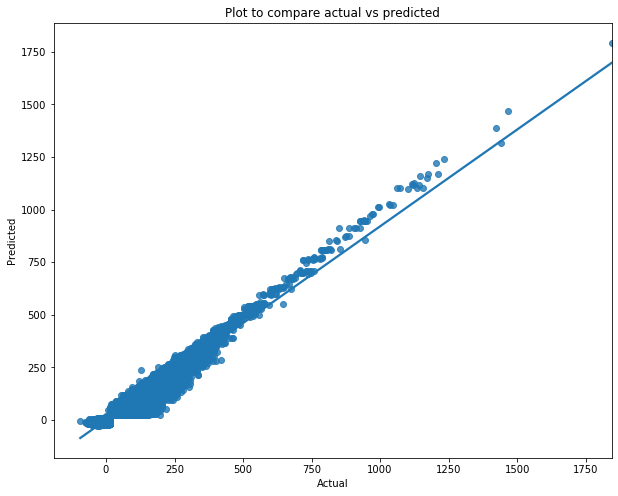

In [67]:
fig, ax = plt.subplots(figsize=(10,8))
sns.regplot(x=y_test, y=y_pred, ax=ax)
plt.title("Plot to compare actual vs predicted")
plt.ylabel("Predicted")
plt.xlabel("Actual")
plt.show()

### Model Prediction

In [68]:
testset = pd.read_csv("test.csv")

In [69]:
answer = xgb.predict(testset)

In [70]:
answer

array([ -1.4121811,  -8.690234 ,  -5.9367905, -12.77518  ,   2.401476 ,
         6.7648377,  -7.2576375, 276.25595  ,  -3.9215574, -13.714125 ,
        -7.980096 ,   5.7324233, -10.300546 , -11.457026 ,  -6.217881 ,
        -4.9852533,  -9.53837  , -10.653729 ,  -5.402088 ,  -5.440386 ,
        -6.717321 ,  -3.8728337, -11.331698 ,   4.623939 ,   3.5409627],
      dtype=float32)

In [71]:
answer = pd.DataFrame(answer, columns=['ArrDelay Prediction'])

In [72]:
answer

,ArrDelay Prediction
0,-1.412181
1,-8.690234
2,-5.936790
3,-12.775180
4,2.401476
5,6.764838
6,-7.257638
7,276.255951
8,-3.921557
9,-13.714125
